# Model Prediksi Biaya Premi Asuransi

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#data splitting
from sklearn.model_selection import train_test_split
#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
#encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

#missing value treatment
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
#column transformer
from sklearn.compose import ColumnTransformer
#pipeline (menggabungkan beberapa tahapan jadi 1)
from sklearn.pipeline import Pipeline
#cross validation
from sklearn.model_selection import cross_val_score
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_validate
#model machine learning
import statsmodels.api as sm # model interpretation
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
#evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error,mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb 

# 1. Import dataset

In [100]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1
...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830,0
1334,18,0,31.920,0,0,0,2205.98080,1
1335,18,0,36.850,0,0,2,1629.83350,1
1336,21,0,25.800,0,0,3,2007.94500,0


## Data Understanding


| Kolom        | Tipe Data | Penjelasan |
|--------------|-----------|------------|
| `age`        | Integer   | Usia pemegang polis (dalam tahun) |
| `sex`        | Categorical (`male`/`female`) | Jenis kelamin nasabah |
| `bmi`        | Float     | Body Mass Index (Indeks Massa Tubuh), menunjukkan tingkat kegemukan |
| `children`   | Integer   | Jumlah anak tanggungan yang diasuransikan |
| `smoker`     | Categorical (`yes`/`no`) | Apakah nasabah adalah perokok |
| `region`     | Categorical (`northeast`, `northwest`, `southeast`, `southwest`) | Wilayah tempat tinggal nasabah |
| `charges`    | Float     | Total biaya premi asuransi yang dikenakan (dalam USD) – ini adalah **variabel target** |

---

# 2. Business Understanding


Perusahaan asuransi kesehatan ingin memahami faktor-faktor apa saja yang mempengaruhi **biaya premi asuransi (`charges`)** yang dikenakan kepada pelanggan. Dengan memahami pola ini, perusahaan dapat:

- Mengembangkan model prediktif untuk **menentukan premi** berdasarkan karakteristik individu.
- Mengetahui **risiko kesehatan** pelanggan berdasarkan faktor-faktor seperti usia, BMI, dan kebiasaan merokok.
- Membantu dalam **segmentasi pelanggan** dan perencanaan strategi pemasaran atau produk.
- Mendeteksi kemungkinan **overcharging** atau **undercharging** terhadap kelompok tertentu.

Tujuan akhir dari analisis ini adalah **mengoptimalkan pendapatan** dan **mengurangi risiko** bagi perusahaan asuransi sambil tetap menjaga keadilan bagi nasabah.


# 3. Data Cleansing

## Missing value

In [101]:
df.isna().sum()

age               0
sex               0
bmi               0
children          0
smoker            0
region            0
charges           0
insuranceclaim    0
dtype: int64

## Duplikasi data

In [102]:
df.duplicated().sum()
# hapus duplikat karena tidak terlalu besar

1

In [103]:
df.drop_duplicates(inplace=True)

In [104]:
df.drop(columns = ['insuranceclaim'], inplace = True)

In [105]:
df.nunique().sort_values()


sex            2
smoker         2
region         4
children       6
age           47
bmi          548
charges     1337
dtype: int64

## cek tipe data

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   int64  
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   int64  
 5   region    1337 non-null   int64  
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 83.6 KB


# 4. EDA

## Distribution feature

In [107]:
numerical_columns = ['age','bmi','children','charges']

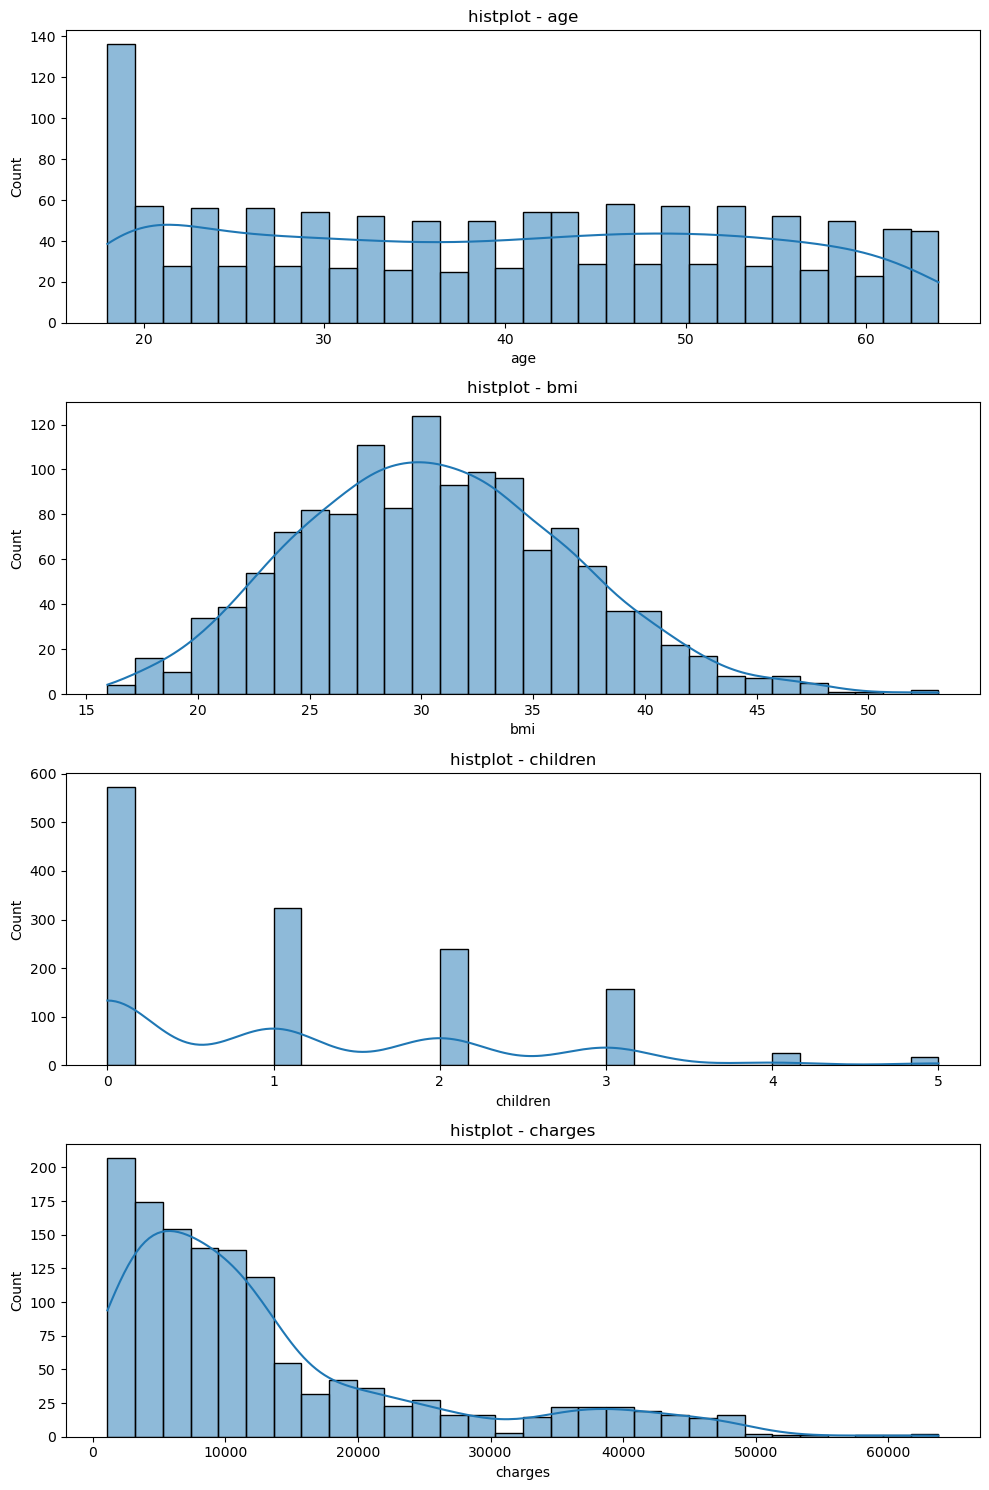

In [108]:
# Boxplots untuk semua kolom numerik
plt.figure(figsize=(10,15))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f'histplot - {col}')
plt.tight_layout()
plt.show()

Insight: setiap kolom memilikidistribusi yang berbeda beda, bila dilihat semua kolom dapat dikatakan masuk akal dan tidak terdapat anomali

<Axes: xlabel='charges'>

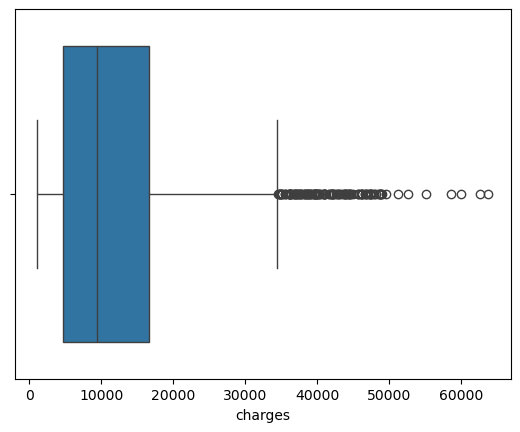

In [109]:
sns.boxplot(data=df, x='charges')


Hati hati terhadap target yang memiliki banyak outlier atau tidak berdistribusi normal karena dapat mempengaruhi model. charges tidak dihapus karena Outlier dianggap data yang valid
   -  Biaya asuransi tinggi itu wajar untuk orang dengan risiko kesehatan besar.
   -  Outlier mencerminkan realitas bisnis yang penting untuk dipertahankan (misalnya, nasabah perokok usia tua dengan BMI tinggi wajar membayar mahal).

## Cek korelasi

In [110]:

df.select_dtypes(include=['int64','float64']).corr(method = 'spearman')

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.019748,0.107897,0.055813,-0.025798,0.003764,0.533523
sex,-0.019748,1.000000,0.044777,0.016372,0.076596,0.004973,0.010748
bmi,0.107897,0.044777,1.000000,0.015643,0.002216,0.152960,0.119585
children,0.055813,0.016372,0.015643,1.000000,0.016199,0.010228,0.132200
smoker,-0.025798,0.076596,0.002216,0.016199,1.000000,-0.002361,0.663611
region,0.003764,0.004973,0.152960,0.010228,-0.002361,1.000000,-0.044142
charges,0.533523,0.010748,0.119585,0.132200,0.663611,-0.044142,1.000000


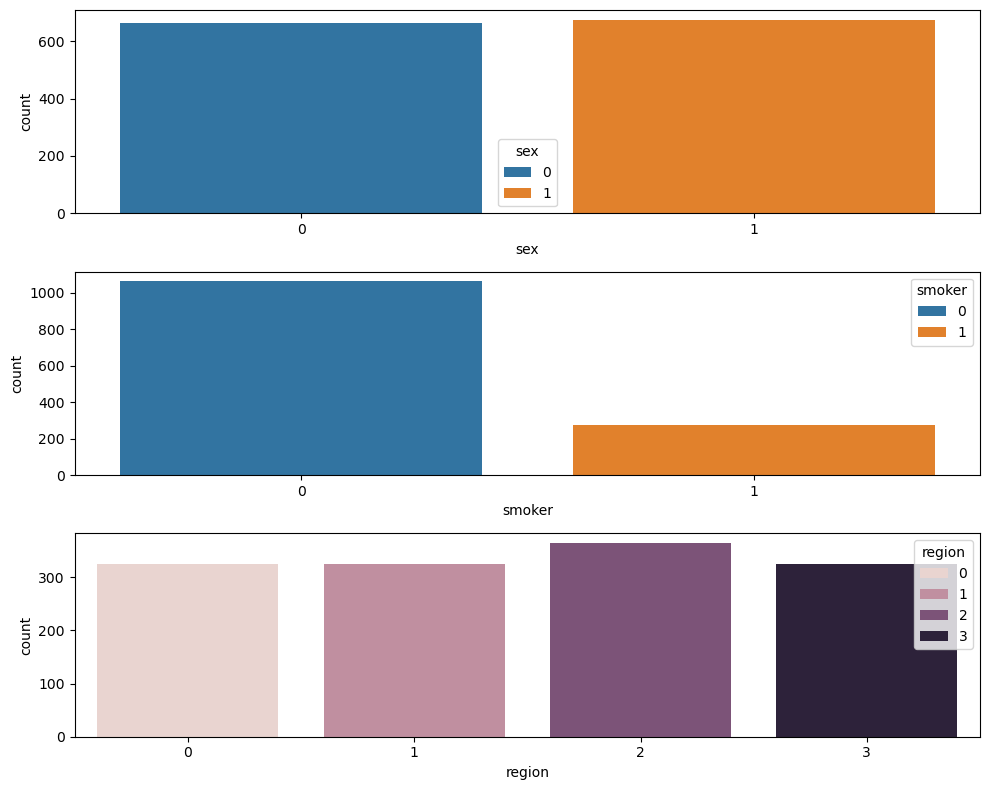

In [111]:
plt.figure(figsize=(10,8))
kat = ['sex','smoker','region']

for i,col in enumerate(kat, 1):
    plt.subplot(len(kat), 1, i)
    sns.countplot(data = df, x = col, hue = col)
plt.tight_layout()
plt.show()

insight : gender female dan male memiliki jumlah yang hampir sama, untuk smoker leboh banyak yang tidak merokok, persebaran negara hampir merata

## Binning

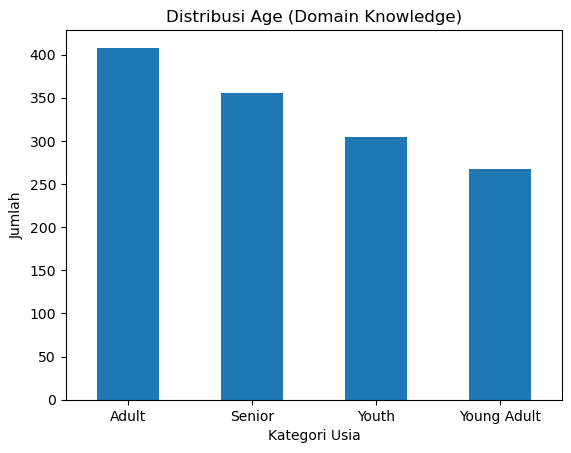

In [112]:
# mengubah kategori umur 

bins = [17, 25, 35, 50, 65] # binss itu titik pemotongan
#(17, 25], (25, 35], (35, 50], (50, 65], (65, 100)]
labels = ['Youth', 'Young Adult', 'Adult', 'Senior']

df['age'] = pd.cut(df['age'], bins=bins, labels=labels)

df['age'].value_counts().plot(kind='bar', title='Distribusi Age (Domain Knowledge)', rot=0)
plt.xlabel('Kategori Usia')
plt.ylabel('Jumlah')
plt.show()

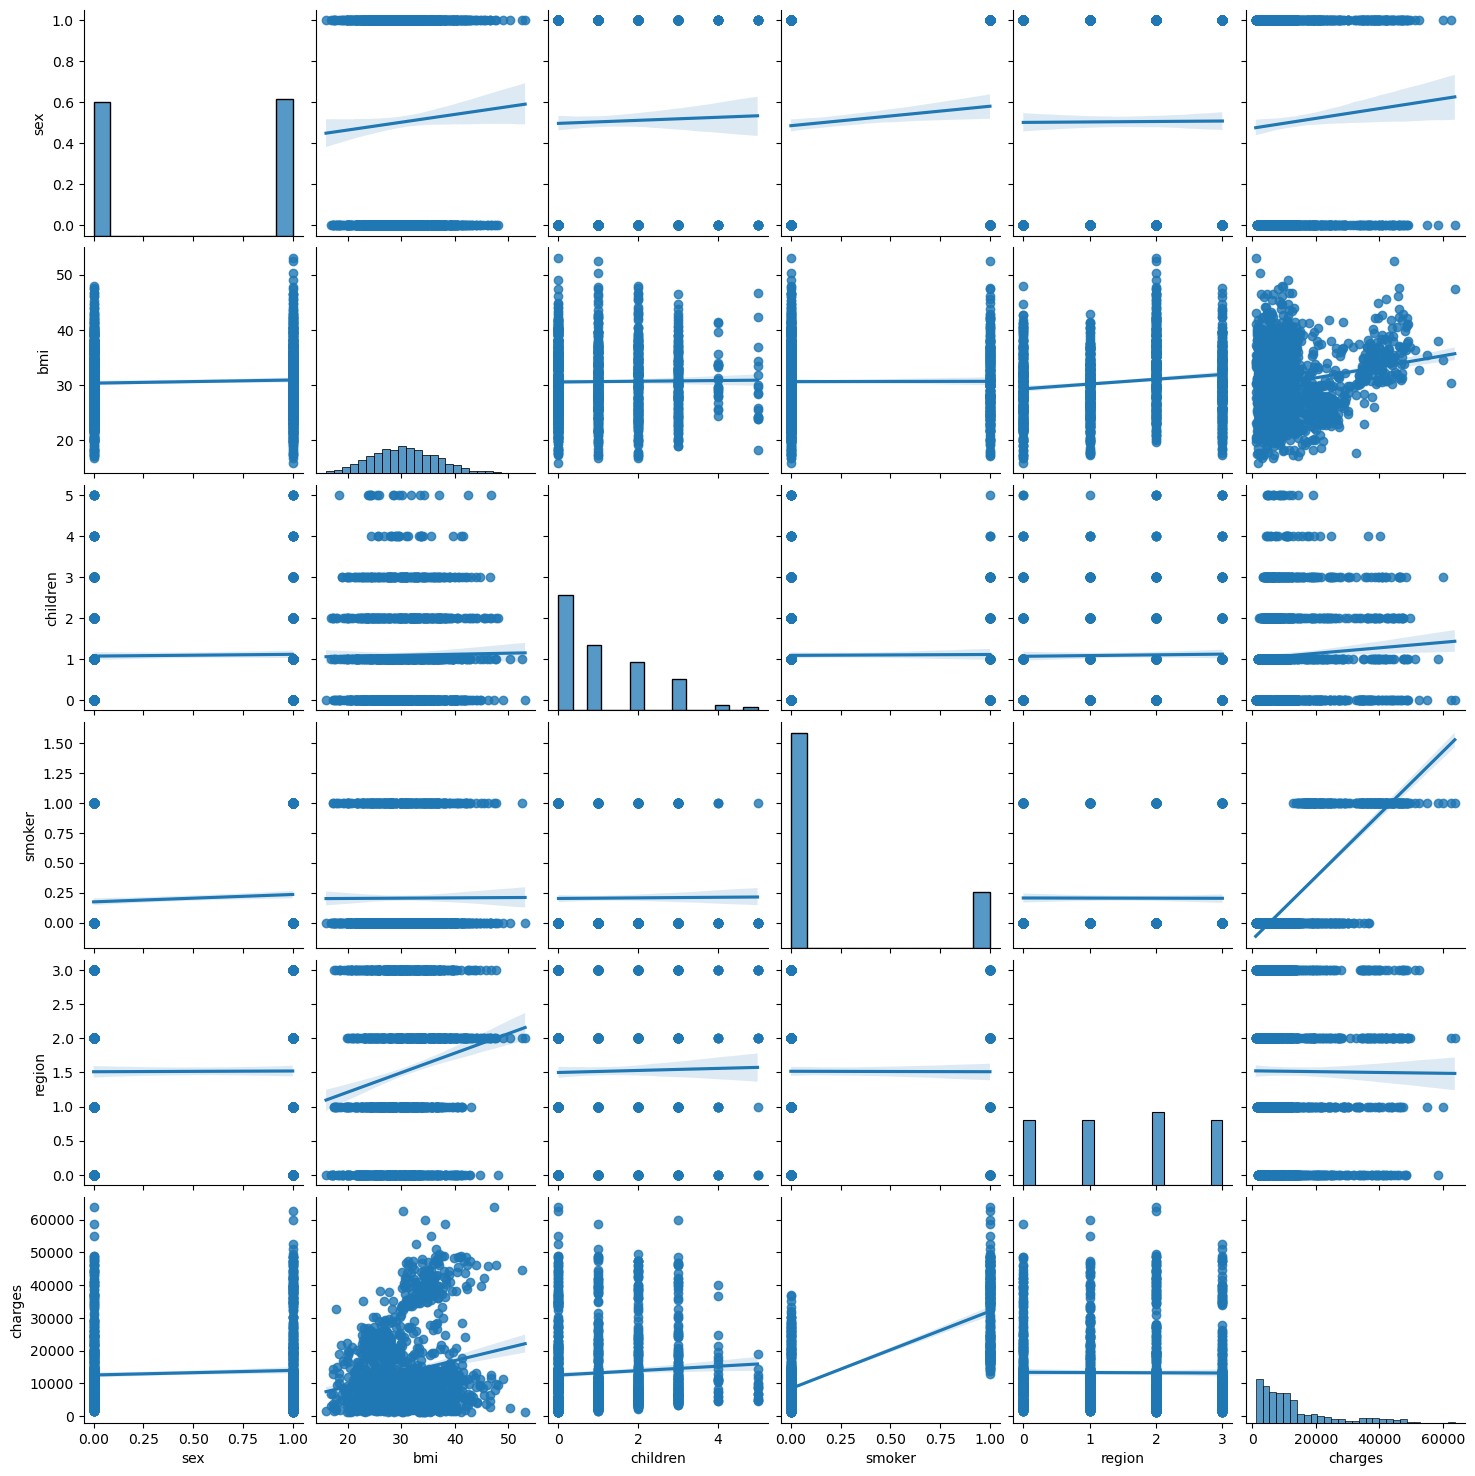

In [113]:
sns.pairplot(data=df, kind = 'reg');

# 5. Data Pre-Processing

Data preprocessing dilakukan dengan cara mengubah seluruh kolom kategorik dan mencoba dengan model linear yaitu linear regresi, lasso dan ridge.
langkah - langkah:

1. Define X dan y sebagai kolom fitur dan Target
2. Mencari kolom Multico, jika ada Kolom dapat di drop
3. Splitting
4. Encoding data yang kategorikal

## Define X dan y

In [114]:
# ubah tipe data untuk one hot
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')
df['region'] = df['region'].astype('category')


In [115]:
y = df['charges']
X = df.drop(columns=['charges'])
X = sm.add_constant(X)

## Multicollinearity
> Pengecekan menggunakan vif

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [117]:
x = pd.get_dummies(X,drop_first=True,dtype=int) 

In [118]:
def vif_calc(x):
    vif = pd.DataFrame() #bikin dataframe
    vif['kolom'] = x.columns #bikin kolom
    vif['VIF']= [variance_inflation_factor(x,i) for i in range(len(x.columns))]
    vif['Acc']= np.where(vif['VIF']>10,'No','Yes')
    return vif

In [119]:
vif_calc(x)

,kolom,VIF,Acc
0,const,32.730051,No
1,bmi,1.106575,Yes
2,children,1.079046,Yes
3,age_Young Adult,1.551830,Yes
4,age_Adult,1.723756,Yes
5,age_Senior,1.616006,Yes
6,sex_1,1.008941,Yes
7,smoker_1,1.012815,Yes
8,region_1,1.517961,Yes
9,region_2,1.651812,Yes


Tidak ada kolom multicollinearity

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   category
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(4), float64(2), int64(1)
memory usage: 47.6 KB


## Train test spliting

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data preparation

In [122]:
lin_reg = LinearRegression()
laso = Lasso()
ridge = Ridge()
from sklearn.preprocessing import PolynomialFeatures
from category_encoders import OrdinalEncoder as CEOrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
# Column names
categorical_onehot = ['sex', 'smoker', 'region']
ordinal_cols = ['age']

# ColumnTransformer, data preparation
transformer1 = ColumnTransformer([
    # If you use sklearn's OrdinalEncoder, don't pass mapping
    ('ordinal', OrdinalEncoder(categories=[['Youth', 'Young Adult', 'Adult', 'Senior']]), ordinal_cols),
    ("onehot", OneHotEncoder(drop='first'), categorical_onehot)
], remainder='passthrough')


# list model
model = [lin_reg,laso,ridge]

# metrics
list_scorer = ['neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error', 'neg_mean_squared_error','r2']


# list kosong
list_mean_rmse = []
list_std_rmse = []

list_mean_mape_before = []
list_std_mape_before = []

list_mean_mse = []
list_std_mse = []

list_mean_r2= []
list_std_r2= []


list_all = []

# looping model dengan pipeline
for i in model:
    pipe_prep_model = Pipeline([('preprocesing', transformer1),('model',i)])
    crosval = cross_validate(estimator= pipe_prep_model, X = X_train, y = y_train, scoring=list_scorer, cv=5)

    list_all.append(crosval)
    list_mean_rmse.append(crosval['test_neg_root_mean_squared_error'].mean())
    list_std_rmse.append(crosval['test_neg_root_mean_squared_error'].std())

    list_mean_mape_before.append(crosval['test_neg_mean_absolute_percentage_error'].mean())
    list_std_mape_before.append(crosval['test_neg_mean_absolute_percentage_error'].std())
     
    list_mean_mse.append(crosval['test_neg_mean_squared_error'].mean())
    list_std_mse.append(crosval['test_neg_mean_squared_error'].std())
    list_mean_r2.append(crosval['test_r2'].mean())
    list_std_r2.append(crosval['test_r2'].std())



## Hasil Model Awal

In [123]:
df_model_cv_before = pd.DataFrame()
df_model_cv_before['model'] = model
df_model_cv_before['mean_rmse'] = list_mean_rmse
df_model_cv_before['std_rmse'] = list_std_rmse

df_model_cv_before['mean_mape'] = list_mean_mape_before
df_model_cv_before['std_mape'] = list_std_mape_before

df_model_cv_before['mean_mse'] = list_mean_mse
df_model_cv_before['std_mse'] = list_std_mse

df_model_cv_before['mean_r2'] = list_mean_r2
df_model_cv_before['std_r2'] = list_std_r2


df_model_cv_before

,model,mean_rmse,std_rmse,mean_mape,std_mape,mean_mse,std_mse,mean_r2,std_r2
0,LinearRegression(),-6250.987985,399.775834,-0.455259,0.020399,-3.923467e+07,5.112575e+06,0.713178,0.027835
1,Lasso(),-6250.763011,399.810880,-0.455385,0.020403,-3.923189e+07,5.112855e+06,0.713200,0.027819
2,Ridge(),-6250.136340,403.384693,-0.457319,0.020628,-3.922692e+07,5.161559e+06,0.713282,0.027778


insight: Dari model awal diambil 3 metode linear yaitu linearregession, lasso dan ridge. Ketiga model awal memiliki nilai rata rata MAPE  masih terlalu besar direntang eror 45 persen. Oleh karena itu diperlukan penambahan model dan transformas model

## Melihat Imbalance

In [124]:
for i in model:
    pipe_gradboost = Pipeline([
        ('preprocessing', transformer1),
        ('model', i)
    ])

    # Fit di training set
    pipe_gradboost.fit(X_train, y_train)

    # Prediksi di train dan test
    y_pred_train_before = pipe_gradboost.predict(X_train)
    y_pred_test_before = pipe_gradboost.predict(X_test)

    # Hitung MAPE
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train_before)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test_before)

    print(f"MAPE Train {i} : {mape_train:.4f}")
    print(f"MAPE Test  {i}: {mape_test:.4f}")

MAPE Train LinearRegression() : 0.4543
MAPE Test  LinearRegression(): 0.4416
MAPE Train Lasso() : 0.4544
MAPE Test  Lasso(): 0.4417
MAPE Train Ridge() : 0.4559
MAPE Test  Ridge(): 0.4441


Nilai test dan train tidak mengamali overfitting tetapi cukup besar nilai erornya bila dilihat dari rata rata MAPE

# 6.Benchmarking Model untuk Prediksi
Diperlukan model sebagai barometer pengerjaan machine learning untuk memprediksi nilai Value. Model yang digunakan adalah:
1. Linear regession
2. KNN
3. Decission Tree
4. Xgboost
5. gradboost
6. lasso
7. ridge

In [125]:
lin_reg = LinearRegression()
knn = KNeighborsRegressor()
dt_reg = DecisionTreeRegressor()
catboost = CatBoostRegressor(verbose=0)
xgboost = xgb.XGBRegressor()
gradboost = GradientBoostingRegressor()
laso = Lasso()
ridge = Ridge()
from sklearn.preprocessing import PolynomialFeatures

# Column names
categorical_onehot = ['sex', 'smoker', 'region']


ordinal_cols = ['age']

bmi_cols = ['bmi','children']



pipe_ordinal_scaling = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[['Youth', 'Young Adult', 'Adult', 'Senior']])),
    ('scaling', RobustScaler())
])

pipe_onehot_scaling = Pipeline([
   ('onehot', OneHotEncoder(drop='first', sparse_output=False)),
   ('scaling', RobustScaler())
])


transformer2 = ColumnTransformer([
    ('ordinal', pipe_ordinal_scaling, ordinal_cols),
    ('onehot', pipe_onehot_scaling, categorical_onehot),  # Gunakan pipeline yang sudah dibuat
    ('scale', RobustScaler(), bmi_cols)
], remainder='passthrough')



# list model
model = [lin_reg, knn, dt_reg,catboost,xgboost,gradboost,laso,ridge]

# metrics
list_scorer = ['neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error', 'neg_mean_squared_error','r2']


# list kosong
list_mean_rmse = []
list_std_rmse = []

list_mean_mape = []
list_std_mape = []

list_mean_mse = []
list_std_mse = []

list_mean_r2= []
list_std_r2= []


list_all = []

# looping model dengan pipeline
for i in model:
    pipe_prep_model = Pipeline([('preprocesing', transformer2),('model',i)])
    crosval = cross_validate(estimator= pipe_prep_model, X = X_train, y = y_train, scoring=list_scorer, cv=5)

    list_all.append(crosval)
    list_mean_rmse.append(crosval['test_neg_root_mean_squared_error'].mean())
    list_std_rmse.append(crosval['test_neg_root_mean_squared_error'].std())

    list_mean_mape.append(crosval['test_neg_mean_absolute_percentage_error'].mean())
    list_std_mape.append(np.abs(crosval['test_neg_mean_absolute_percentage_error'].std()))
     
    list_mean_mse.append(crosval['test_neg_mean_squared_error'].mean())
    list_std_mse.append(crosval['test_neg_mean_squared_error'].std())
    
    list_mean_r2.append(crosval['test_r2'].mean())
    list_std_r2.append(crosval['test_r2'].std())



insight: Menambahkan model knn, DT, Catboost, Catboost dan gradient boostingserta menambahkan scaling pada setiap kolom numerik. 

In [126]:
for i in model:
    pipe_gradboost = Pipeline([
        ('preprocessing', transformer2),
        ('model', i)
    ])

    # Fit di training set
    pipe_gradboost.fit(X_train, y_train)

    # Prediksi di train dan test
    y_pred_train_before = pipe_gradboost.predict(X_train)
    y_pred_test_before = pipe_gradboost.predict(X_test)

    # Hitung MAPE
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train_before)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test_before)

    print(f"MAPE Train {i} : {mape_train:.4f}")
    print(f"MAPE Test  {i}: {mape_test:.4f}")

MAPE Train LinearRegression() : 0.4543
MAPE Test  LinearRegression(): 0.4416
MAPE Train KNeighborsRegressor() : 0.3389
MAPE Test  KNeighborsRegressor(): 0.4010
MAPE Train DecisionTreeRegressor() : 0.0048
MAPE Test  DecisionTreeRegressor(): 0.4833
MAPE Train <catboost.core.CatBoostRegressor object at 0x000001731CB782F0> : 0.2314
MAPE Test  <catboost.core.CatBoostRegressor object at 0x000001731CB782F0>: 0.4082
MAPE Train XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None

In [127]:
df_model_cv_before = pd.DataFrame()
df_model_cv_before['model'] = model
df_model_cv_before['mean_rmse'] = list_mean_rmse
df_model_cv_before['std_rmse'] = list_std_rmse


df_model_cv_before['mean_mape'] = list_mean_mape
df_model_cv_before['std_mape'] = list_std_mape

df_model_cv_before['mean_mse'] = list_mean_mse
df_model_cv_before['std_mse'] = list_std_mse

df_model_cv_before['mean_r2'] = list_mean_r2
df_model_cv_before['std_r2'] = list_std_r2


df_model_cv_before

,model,mean_rmse,std_rmse,mean_mape,std_mape,mean_mse,std_mse,mean_r2,std_r2
0,LinearRegression(),-6250.987985,399.775834,-0.455259,0.020399,-3.923467e+07,5.112575e+06,0.713178,0.027835
1,KNeighborsRegressor(),-6171.532495,418.333831,-0.425837,0.033400,-3.826282e+07,5.324009e+06,0.721226,0.020025
2,DecisionTreeRegressor(),-6624.791007,318.405952,-0.459062,0.086438,-4.398924e+07,4.166052e+06,0.677487,0.029241
3,<catboost.core.CatBoostRegressor object at 0x0...,-5097.354970,351.751917,-0.375831,0.022134,-2.610676e+07,3.689334e+06,0.809175,0.020947
4,"XGBRegressor(base_score=None, booster=None, ca...",-5669.829949,269.475872,-0.438827,0.036397,-3.221959e+07,3.098647e+06,0.763934,0.019958
5,([DecisionTreeRegressor(criterion='friedman_ms...,-4879.220493,373.665641,-0.351361,0.009869,-2.394642e+07,3.791182e+06,0.825183,0.020415
6,Lasso(),-6250.769122,399.748638,-0.455320,0.020411,-3.923191e+07,5.112066e+06,0.713200,0.027813
7,Ridge(),-6250.170015,402.722306,-0.457362,0.020665,-3.922681e+07,5.153201e+06,0.713281,0.027712


insight: hasil remodeling tidak terlalu berbeda jauh dengan hasil model awal.
Model terbaik dengan nilai persen mape terkecil adalah model GradientBoostingRegressor

# 7. Hyperparameter Tuning

In [128]:
gradboost = GradientBoostingRegressor(random_state=42)

pipe_prep_model = Pipeline([
    ('preprocessing', transformer2),
    ('model', gradboost)
])

# Hyperparameter untuk Gradient Boosting
hyperparameter = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [10, 20, 30],
    'model__min_samples_leaf': [5, 10, 20],
    'model__subsample': [0.8, 1.0],
    'model__loss': ['squared_error', 'absolute_error']  # Pilihan loss function regresi
}

# GridSearchCV untuk Gradient Boosting Regressor
grid_model = GridSearchCV(
    estimator=pipe_prep_model,
    param_grid=hyperparameter,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1
)

In [129]:
pipe_gradboost = Pipeline([
    ('preprocessing', transformer2),
    ('model', gradboost)
])

# Fit di training set
pipe_gradboost.fit(X_train, y_train)

# Prediksi di train dan test
y_pred_train = pipe_gradboost.predict(X_train)
y_pred_test = pipe_gradboost.predict(X_test)

# Hitung MAPE
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"MAPE Train (Gradient Boosting): {mape_train:.4f}")
print(f"MAPE Test  (Gradient Boosting): {mape_test:.4f}")

MAPE Train (Gradient Boosting): 0.3004
MAPE Test  (Gradient Boosting): 0.3586


In [130]:
grid_model.fit(X_train, y_train)

c:\Users\cacab\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(categories=[['Youth',
                                                                                                                      'Young '
                                                                                                                      'Adult',
                                                                                                                      'Adult',
                                                                                                                      'Senior']])),
                                                                                         ('scaling',
                                                                                          RobustScaler())]),
                                                                         ['age']),
                                                                        ('onehot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False)),...
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__loss': ['squared_error', 'absolute_error'],
                         'model__max_depth': [3, 5, 7],
                         'model__min_samples_leaf': [5, 10, 20],
                         'model__min_samples_split': [10, 20, 30],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_percentage_error')

Insight: setelah hyperparameter menggunakan model terbaik yaitu gradienboosting dengan spesifikasi 

GradientBoostingRegressor(learning_rate=0.05, loss='absolute_error',
                          min_samples_leaf=10, min_samples_split=10,
                          n_estimators=200, random_state=42, subsample=0.8)

In [131]:
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__loss,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
338,1.441405,0.121892,0.016928,0.003540,0.05,absolute_error,3,10,10,200,0.8,"{'model__learning_rate': 0.05, 'model__loss': ...",-0.174049,-0.160334,-0.170798,-0.162015,-0.164512,-0.166342,0.005243,1
342,1.453834,0.069208,0.028653,0.005632,0.05,absolute_error,3,10,20,200,0.8,"{'model__learning_rate': 0.05, 'model__loss': ...",-0.174049,-0.160334,-0.170798,-0.162015,-0.164512,-0.166342,0.005243,1
346,1.419089,0.094783,0.023064,0.004422,0.05,absolute_error,3,10,30,200,0.8,"{'model__learning_rate': 0.05, 'model__loss': ...",-0.174621,-0.162565,-0.171963,-0.161969,-0.166051,-0.167434,0.005053,3


In [136]:
best_model = grid_model.best_estimator_

best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
y_pred_best

mean_absolute_percentage_error(y_test, y_pred_best) 

0.15192319526220358

- Model sebelum tuning gradientboosting, memiliki error 35%
- Model setelah tuning gradientboosting, memiliki error 15%, turun sekitar 20% dari model sebelum tuning

In [137]:
# Ambil preprocessing step dari pipeline
preprocessor = best_model.named_steps['preprocessing']

# Ambil nama-nama fitur setelah transformasi
feature_names = preprocessor.get_feature_names_out()

# Tampilkan
print(feature_names)


['ordinal__age' 'onehot__sex_1' 'onehot__smoker_1' 'onehot__region_1'
 'onehot__region_2' 'onehot__region_3' 'scale__bmi' 'scale__children'
 'remainder__const']


In [138]:
import pandas as pd

# Transform data
X_transformed = preprocessor.transform(X_train)

# Buat DataFrame dengan nama kolom hasil transformasi
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
X_transformed_df.head()

,ordinal__age,onehot__sex_1,onehot__smoker_1,onehot__region_1,onehot__region_2,onehot__region_3,scale__bmi,scale__children,remainder__const
0,-1.0,0.0,0.0,0.0,0.0,0.0,-0.689697,-0.5,1.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,-0.540000,0.5,1.0
2,0.5,-1.0,0.0,1.0,0.0,0.0,0.887879,0.5,1.0
3,0.5,0.0,0.0,0.0,1.0,0.0,1.366061,-0.5,1.0
4,0.0,-1.0,0.0,0.0,0.0,0.0,-0.436364,0.5,1.0


# 8. Model Interpretation 

In [135]:
import shap

In [140]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set seed untuk reproducibility
np.random.seed(123)

# Training model
best_model.fit(X_train, y_train)

# Prediksi
y_pred_gb = best_model.predict(X_test)

# Evaluasi
print("MAE :", mean_absolute_error(y_test, y_pred_gb))
print

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MAPE Test  (Gradient Boosting): {mape_test:.4f}")

MAE : 2076.9159374259766
MAPE Test  (Gradient Boosting): 0.3586


In [ ]:
shap.TreeExplainer

shap.explainers._tree.TreeExplainer

In [144]:
def shap_plot(j, model, S):

    # define explainer
    explainerModel = shap.TreeExplainer(model)

    # shap value untuk baris tertentu
    shap_values_Model = explainerModel.shap_values(S)

    # force_plot
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])

    return(p)

In [146]:

# Training model
best_model.fit(X_train, y_train)

c:\Users\cacab\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['Youth',
                                                                                               'Young '
                                                                                               'Adult',
                                                                                               'Adult',
                                                                                               'Senior']])),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scale', RobustScaler(),
                                                  ['bmi', 'children'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           loss='absolute_error',
                                           min_samples_leaf=10,
                                           min_samples_split=10,
                                           n_estimators=200, random_state=42,
                                           subsample=0.8))])

In [147]:
# **Hanya fit dan transform pada data training**
X_train_transformed = transformer1.fit_transform(X_train)

# **Hanya transform pada data test (tanpa fitting ulang)**
X_test_transformed = transformer1.transform(X_test)



C:\Users\cacab\AppData\Local\Temp\ipykernel_20144\856822965.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


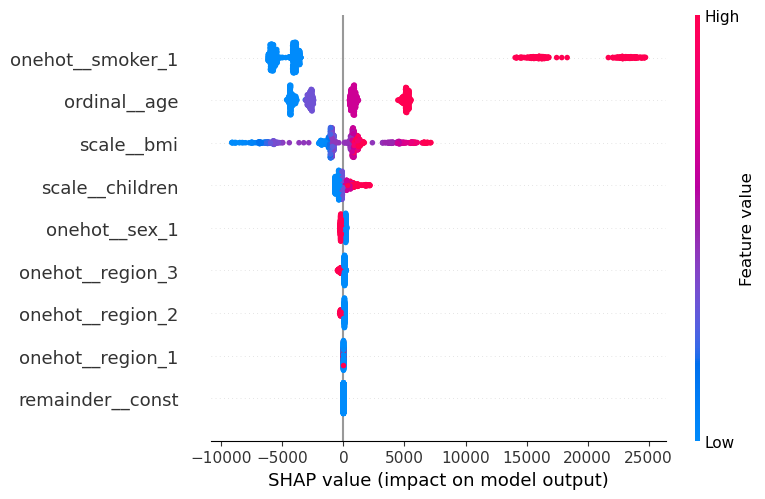

In [148]:
# 1. Ambil bagian preprocessing dan model dari pipeline
preprocessor = best_model.named_steps['preprocessing']
model = best_model.named_steps['model']

# 2. Transformasikan X_train
X_train_transformed = preprocessor.transform(X_train)

# 3. Gunakan TreeExplainer hanya pada model pohon
explainer = shap.Explainer(model, X_train_transformed)

# 4. Hitung SHAP values
shap_values = explainer(X_train_transformed)

# 5. Dapatkan nama fitur (kalau preprocessor mendukung)
feature_names = preprocessor.get_feature_names_out()

# 6. Buat SHAP summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


- orang yang merokok mendapatkan charges atau premi lebih tinggi dibanding orang yang tidak merokok
- Umur yang tua mendapatkan charges atau premi lebih tinggi dibanding orang yang berusia muda
- Orang dengan BMI tinggi mendapatkan charges atau premi lebih tinggi dibanding orang yang BMI rendah
- orang yang mempunyai anak banyak mendapatkan charges atau premi lebih tinggi dibanding orang yang mempunyai anak sedikit
- perempuan mendapatkan charges atau premi lebih tinggi dibanding laki laki


# 9. Deployment and conclusion interpretasi

In [149]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# 1. Pastikan model sudah di-training
best_model = Pipeline([
    ('preprocessor', transformer1),
    ('GBOOST', GradientBoostingRegressor(learning_rate=0.05, loss='absolute_error',
                          min_samples_leaf=10, min_samples_split=10,
                          n_estimators=200, random_state=42, subsample=0.8))  # Gunakan nama step 'rf'
])
best_model.fit(X_train, y_train)

# 2. Ambil model dengan nama step yang benar
actual_model = best_model.named_steps['GBOOST']

# 3. Persiapkan data test
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# 4. Gunakan SHAP
explainer = shap.TreeExplainer(actual_model)
shap_values = explainer.shap_values(X_test_df)

# Visualisasi
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[8], X_test_df.iloc[8])

In [150]:
df[df['bmi']== 35.64]

,age,sex,bmi,children,smoker,region,charges
415,Adult,0,35.64,1,0,2,7345.7266


hasil prediksi dibandingkan dengan hasil actual. orang yang memiliki kategori usia dewasa perempuan dengan bmi 35.64 dan memiliki anak 1 dikenakan tarif premi sebesar 7.345 dollar hasil prediksi menunjukan tarif premi sebesar 7.658. Hal ini sesuai dengan nilai MAE atau Mean Absolut Eror sebesar 2.078 kurang lebih dari nilai actual.

In [151]:
shap.force_plot(explainer.expected_value, shap_values[10], X_test_df.iloc[10])

In [152]:
df[df['bmi']== 21.09]

,age,sex,bmi,children,smoker,region,charges
370,Senior,0,21.09,0,0,1,13415.0381


hasil prediksi dibandingkan dengan hasil actual. orang yang memiliki kategori usia senior perempuan dengan bmi 21.09 dan memiliki anak 0 dikenakan tarif premi sebesar 13.415 dollar hasil prediksi menunjukan tarif premi sebesar 11.763 dollar. Hal ini sesuai dengan nilai MAE atau Mean Absolut Eror sebesar 2.078 kurang lebih dari nilai actual.

In [158]:
import joblib

In [159]:
# fit
best_model.fit(X, y)

# save model
joblib.dump(best_model, 'model_gradboost_joblib')

['model_gradboost_joblib']

In [160]:
model_loaded_joblib = joblib.load('model_gradboost_joblib')
model_loaded_joblib

c:\Users\cacab\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Youth',
                                                                              'Young '
                                                                              'Adult',
                                                                              'Adult',
                                                                              'Senior']]),
                                                  ['age']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('GBOOST',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           loss='absolute_error',
                                           min_samples_leaf=10,
                                           min_samples_split=10,
                                           n_estimators=200, random_state=42,
                                           subsample=0.8))])

# Prediksi Premi Asuransi (Insurance Charges Prediction)

## 1. Project Overview

Proyek ini bertujuan untuk memprediksi **biaya premi asuransi (`charges`)** berdasarkan atribut pelanggan seperti usia, jenis kelamin, status merokok, dan lainnya. Prediksi ini sangat berguna bagi perusahaan asuransi untuk:

- Menentukan premi secara adil dan akurat
- Mengidentifikasi faktor-faktor yang mempengaruhi besarnya premi
- Mengoptimalkan strategi underwriting dan pricing

### Key Objectives:


- **Objektif 1:** Memprediksi biaya premi dengan berbagai model regresi  
- **Objektif 2:** Mengevaluasi performa masing-masing model untuk memilih yang terbaik

---

## 2. Data Sources

- **Dataset:** [Insurance Claim Prediction - Top ML Models (Kaggle)](https://www.kaggle.com/code/yasserh/insurance-claim-prediction-top-ml-models)

### Deskripsi Kolom:

| Kolom       | Tipe Data  | Deskripsi |
|-------------|------------|-----------|
| `age`       | Integer    | Usia pemegang polis (tahun) |
| `sex`       | Kategori   | Jenis kelamin (`male`, `female`) |
| `bmi`       | Float      | Body Mass Index |
| `children`  | Integer    | Jumlah anak tanggungan |
| `smoker`    | Kategori   | Status perokok (`yes`, `no`) |
| `region`    | Kategori   | Wilayah tempat tinggal |
| `charges`   | Float      | **Target:** Biaya premi asuransi (USD) |

---

## 3. Technologies Used

- **Bahasa Pemrograman:** Python
- **Library Machine Learning:**  
  - Scikit-learn  
  - XGBoost  
  - CatBoost  
  - Gradient Boosting  
- **Visualisasi:** Seaborn, Matplotlib
- **Pengelolaan Proyek:** Jupyter Notebook, Git

---

## 4. Summary of Findings

### 4.1 Business Insight

- Perokok membayar premi yang **jauh lebih tinggi** dibanding non-perokok.
- Usia dan BMI memiliki korelasi positif terhadap biaya premi.
- gender perempuan membayar premi lebih tinggi
- orang yang memiliki banyak anak memiliki premi lebih tinggi
- Wilayah tinggal tidak terlalu berpengaruh secara signifikan terhadap premi.

---

## 5. Models Used & Evaluation

### Model Regresi yang Digunakan:

- Linear Regression  
- K-Nearest Neighbors Regressor  
- Decision Tree Regressor  
- CatBoost Regressor  
- XGBoost Regressor  
- Gradient Boosting Regressor  
- Lasso Regression  
- Ridge Regression

### Metrik Evaluasi:

- Mean Squared Error (MSE)  
- Mean absolute error (MAE)
- Root Mean Squared Error (RMSE)  
- Mean absolute percentage error(MAPE)
- R² Score (Coefficient of Determination)


